# Figure 6: Plot attention weights entropy.

In an independent foraging setting, attentions should.

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader
from itertools import product
import pandas as pd
import seaborn as sns

In [48]:
from collab_env.data.file_utils import expand_path, get_project_root

In [49]:
from collab_env.gnn.gnn import get_adjcency_from_debug_batch
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from scipy.stats import entropy

import starbars
from scipy.stats import ranksums

## Data

In [50]:
self_loops = True # TOC added 111225 10:48AM
relative_positions = False

In [51]:
data_names = ['boid_food_basic', 'boid_food_independent','boid_food_strong'] #'runpod/boid_single_species_basic']

# set short versions of dataset names
data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

### manual input model, result from model selection

In [52]:
ablation = 0
all_combinations = [
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 6, ablation),
    ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 6, ablation),
    ('boid_food_strong', 'vpluspplus_a', 0, 1, 0.1, 8, ablation)
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 0, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 1, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 2, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 3, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 4, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 5, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 6, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 7, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 8, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 9, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 0, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 1, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 2, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 3, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 4, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 5, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 6, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 7, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 8, ablation),
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 9, ablation),    
    # ('boid_food_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, ablation),
    # or ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
    #    if considering the noised version of the best seed that performed well noiseless
    #    results are the same
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 2, ablation),
    # ('boid_food_strong', 'vpluspplus_a', 0.005, 1, 0.5, 2, ablation)
]

In [53]:
print('all combos ', all_combinations)

all combos  [('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 6, 0), ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 6, 0), ('boid_food_strong', 'vpluspplus_a', 0, 1, 0.1, 8, 0)]


In [54]:
rollout_error = None
models_to_consider = range(3) #[0, 1, 2, 3]

In [55]:
rollout_results =  {}

model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = False
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation,
        "self_loops": self_loops,
        "use_relative_positions": relative_positions, 
    }
    
    data_name_short = data_names_short[data_name]
    if ablation:
        model_save_name = f"{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}{'_selfloops' if self_loops else ''}_ablation"
    else:
        model_save_name = f"{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}{'_selfloops' if self_loops else ''}"

    
    #try:
        
    rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
0, Successfully import foodbasic_
n0_h1_vr0.1_s6_selfloops
ablation  0
1, Successfully import foodidpnt_
n0_h1_vr0.1_s6_selfloops
ablation  0
2, Successfully import foodstrong_
n0_h1_vr0.1_s8_selfloops


In [56]:
datasets = load_various_data(data_names, 1, return_dict = True)

In [57]:
datasets.keys()

dict_keys(['boid_food_basic', 'boid_food_independent', 'boid_food_strong'])

## Parse adjacency matrix

In [58]:
models_to_consider = rollout_results.keys()
print(models_to_consider)

dict_keys([0, 1, 2])


In [59]:
print(model_names)
assert len(model_names) == len(rollout_results.keys())

{0: 'foodbasic_\nn0_h1_vr0.1_s6_selfloops', 1: 'foodidpnt_\nn0_h1_vr0.1_s6_selfloops', 2: 'foodstrong_\nn0_h1_vr0.1_s8_selfloops'}


In [60]:
# creating a dictionary with one specific color per group:

my_pal = {}
for m in rollout_results:

    dataname, model_name, n, h, vr, s,_ = all_combinations[m]
    d = data_names_short[dataname]
    if 'idpnt' in d:
        my_pal[m] = "C1"
    elif 'strong' in d:
        my_pal[m] = "C2"
    else:
        my_pal[m] = "C0"

In [61]:
#ticklabels = [model_names[c] if isinstance(c, int) else c + '\ndata' for c in entropy_dict]
ticklabels = [a[0] for a in all_combinations]
print(ticklabels)

['boid_food_basic', 'boid_food_independent', 'boid_food_strong']


## Plot attention adjacency matrix entries

In [62]:
def return_food_location(species_configs):
    # find food location
    width = species_configs["A"]['width']
    height = species_configs["A"]['height']
    
    food_config = species_configs["food0"]
    x, y = food_config['x']/width, food_config['y']/height

    return [x, y]

In [63]:
def find_boids_close_to_food(food_loc, predicted_xy, species_configs):
    width = species_configs["A"]['width']
    food_visual_range = species_configs['A']["food_visual_range"]
    food_eating_range = species_configs['A']["food_eating_range"]

    dis = np.sqrt(np.sum((predicted_xy - np.array(food_loc).reshape((1,2))) ** 2, axis = 1))

    condition1 = dis <= food_visual_range/width
    condition2 = dis > food_eating_range/width
    
    return np.logical_and(condition1, condition2)

In [64]:

def figure_data_D(rollout_results, datasets, all_combinations, model_index, W, start_frame = 3, start = 0, end = 50):
    """
    this is the old version of the code to produce the figures for the paper
    example: m_x, m_y = ['boid_single_species_basic', 'boid_single_species_independent']
    
    """

    dataname, model_name, n, h, vr, s, _ = all_combinations[model_index]
    dataloader = datasets[dataname]["test_loader"]
    
    _, species = list(dataloader)[0]
    all_bird_ind = species.ravel() == 0 #exclude food/environmental factor
    food_ind = species.ravel() == 1 #food

    num_agents = np.count_nonzero(all_bird_ind)
    #print(food_ind)

    batch_size = rollout_results[0][0]['actual'][0].shape[0]


    if "food" in dataname:
        species_configs = datasets[data_name]["species_configs"]
        food_loc = return_food_location(species_configs)

    entropy_x_all, sum_bird_x_all, sum_food_x_all, sum_bird_diag_all, sum_bird_diag_close_all = [], [], [], [], []
    start_ = start - start_frame
    end_ = start_ + end - start
    # print('keys ', W[0].keys())
    for file in W[0].keys():

        entropy_x_file = []
        sum_bird_x_file = []
        sum_bird_diag_file = []
        sum_bird_diag_close_file = []
        sum_food_x_file = []
        
        batch = int(np.floor(file/batch_size))
        file_within_batch = file % batch_size
        
        for frame in range(start, end):#range(len(models[m_x]["W_output"][0][file])):
            if "food" in dataname:
                predicted = rollout_results[0][batch]['predicted'][frame + start_frame][file_within_batch].squeeze()
                # restrict to the moments when boids can see food
                # so the adjacency matrix entries can have both nonzero boid and food elements.
                # suggested by Dima
                bird_ind = find_boids_close_to_food(food_loc, predicted, species_configs)
    
            else:
                bird_ind = all_bird_ind
            
            # print('bird ind: ', bird_ind)
            # print('all_bird_ind: ', all_bird_ind)
            # bird_ind = all_bird_ind
            # print('num close to food: ', np.sum(bird_ind))
            if len(bird_ind) == 0:
                continue
                  
            # print('W diagonal ', W[0][file][frame][:, all_bird_ind].diagonal())
            #print('W diagonal mean', np.mean(W[0][file][frame][:, all_bird_ind].diagonal()))
            
            '''
            TOC -- 111225 8:59PM
            Zero out the diagonal to figure out the boid to other boid attention level 
            '''
            attention_weights = W[0][file][frame].copy()
            diag_mean_close = np.mean(attention_weights[bird_ind][:, bird_ind].diagonal())
            #diag_mean_close = np.mean(attention_weights[:, bird_ind].diagonal())
            # print('attention weight shape all bird ', attention_weights[all_bird_ind, all_bird_ind].shape)
            # print('len(attention_weights[:, all_bird_ind]).diagonal(): ', len(attention_weights[:, all_bird_ind].diagonal()))
            diag_mean = np.mean(attention_weights[all_bird_ind][: , all_bird_ind].diagonal()) # ditch the food
            np.fill_diagonal(attention_weights, 0.0)
            # x = W[0][file][frame][:,bird_ind]
            x = attention_weights[:,bird_ind]
            # print('x = ', x)
    
            x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
    
            entropy_x = entropy(x_boid, axis = 0)
            entropy_x_file.append(entropy_x)
        
            # sum_bird_x = np.mean(x[bird_ind,:])
            sum_bird_x = np.sum(attention_weights[all_bird_ind][:, all_bird_ind])/(num_agents)
            # sum_food_x = np.mean(x[food_ind,:])
            #sum_food_x = np.mean(W[0][file][frame][bird_ind, food_ind])
            # sum_food_x = np.mean(attention_weights[bird_ind][:, food_ind])
            sum_food_x = np.mean(attention_weights[bird_ind, food_ind])
            # print('attention weight shape bird ind to food ', attention_weights[all_bird_ind, food_ind].shape)
            sum_bird_x_file.append(sum_bird_x)
    
            sum_food_x_file.append(sum_food_x)
        
            
        
            sum_bird_diag_file.append(diag_mean)
            sum_bird_diag_close_file.append(diag_mean_close)

        entropy_x_all.append(np.mean(np.concatenate(entropy_x_file)))
        sum_bird_x_all.append(np.mean(sum_bird_x_file))
        sum_bird_diag_all.append(np.mean(sum_bird_diag_file))
        sum_bird_diag_close_all.append(np.mean(sum_bird_diag_close_file))
        sum_food_x_all.append(np.mean(sum_food_x_file))
    
    
    return entropy_x_all, sum_bird_x_all, sum_food_x_all, sum_bird_diag_all, sum_bird_diag_close_all

In [65]:
STARTING_FRAME = 5
ENDING_FRAME = 55
MODEL_STARTING_FRAME = 3
NODE_NUM = 21 # 21 boids + 1 food

entropy_dict = {}
ratio_dict = {}
W_output_all = {}

for m in models_to_consider: #rollout_results:
    print(f"Parsing model {m}")
    
    dataname, model_name, n, h, vr, s, _ = all_combinations[ind]
    dataloader = datasets[dataname]["test_loader"]
    
    W_input, W_output = get_adjcency_from_debug_batch(
            rollout_results[m], dataloader, vr, STARTING_FRAME, ENDING_FRAME, MODEL_STARTING_FRAME, NODE_NUM
        )

    W_output_all[m] = W_output
    #print(f"W_output[{m}] diagonal = {W_output.diagonal()}")

Parsing model 0


/Users/tc/ArchivedBoxSync/Research/Basis/collab-env-stuff/collab-gnn-updates/collab-environment/collab_env/gnn/gnn.py:273: RuntimeWarning: invalid value encountered in divide
  A_output = A / col_sum[np.newaxis, :]


Parsing model 1
Parsing model 2


In [66]:
MODEL_START_TIME = 5 #: W_output_all starts to record at frame 5
start = 0
end = 50

entropy_all = {}
sum_bird_close = {}
sum_food_close = {}
sum_agent_to_self = {}
sum_diag_close = {}
for m in models_to_consider:
    entropy_all[m], sum_bird_close[m], sum_food_close[m], sum_agent_to_self[m], sum_diag_close[m] = figure_data_D(
        rollout_results[m], datasets, all_combinations, m, W_output_all[m], MODEL_START_TIME, start, end)
      


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_2879/3055533890.py:76: RuntimeWarning: invalid value encountered in divide
  x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
/Users/tc/VirtualEnvironments/collab-environment-gnn-310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tc/VirtualEnvironments/collab-environment-gnn-310/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [67]:
        
sum_food_close_df = pd.DataFrame(sum_food_close)
sum_bird_close_df = pd.DataFrame(sum_bird_close)
sum_diag_close_df = pd.DataFrame(sum_diag_close)


for i in range(len(sum_agent_to_self)): 
    print(f'diag {i} mean ', np.mean(sum_agent_to_self[i]), len(sum_agent_to_self[i]), np.nanmean(sum_diag_close[i]), np.count_nonzero(~np.isnan(sum_diag_close[i])), np.nanmean(sum_food_close[i]), np.count_nonzero(~np.isnan(sum_food_close[i])), all_combinations[i] )

_, pvalue_boid_gt_ind = ranksums(sum_diag_close_df[0], sum_diag_close_df[1],'less',nan_policy = 'omit')
_, pvalue_boid_gt_strong = ranksums(sum_diag_close_df[0], sum_diag_close_df[2],'less',nan_policy = 'omit')
_, pvalue_boid = ranksums(sum_bird_close_df[0], sum_food_close_df[0],'two-sided',nan_policy = 'omit')
_, pvalue_ind = ranksums(sum_bird_close_df[1], sum_food_close_df[1],'less',nan_policy = 'omit')
_, pvalue_strong_boid_to_food = ranksums(sum_bird_close_df[2], sum_food_close_df[2],'less',nan_policy = 'omit')
_, pvalue_boid_strong_food = ranksums(sum_food_close_df[0], sum_food_close_df[2],'less',nan_policy = 'omit')


#print(pvalue01_boid_gt_ind, pvalue02_boid_lt_strong, pvalue03_boid, pvalue04_ind, pvalue05_strong )
print(pvalue_boid_gt_ind, pvalue_boid_gt_strong, pvalue_boid, pvalue_ind, pvalue_strong_boid_to_food, pvalue_boid_strong_food)


diag 0 mean  0.9708902 300 0.95242256 281 0.02197041 281 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 6, 0)
diag 1 mean  0.9991973 300 0.9989444 298 9.830115e-05 298 ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 6, 0)
diag 2 mean  0.9680485 300 0.96480995 288 0.018591806 288 ('boid_food_strong', 'vpluspplus_a', 0, 1, 0.1, 8, 0)
1.6949029943100063e-96 1.9525776378989e-06 1.0802312021001696e-13 1.0 1.0 0.9999753471727146


3.0 0.03


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_2879/3480110730.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


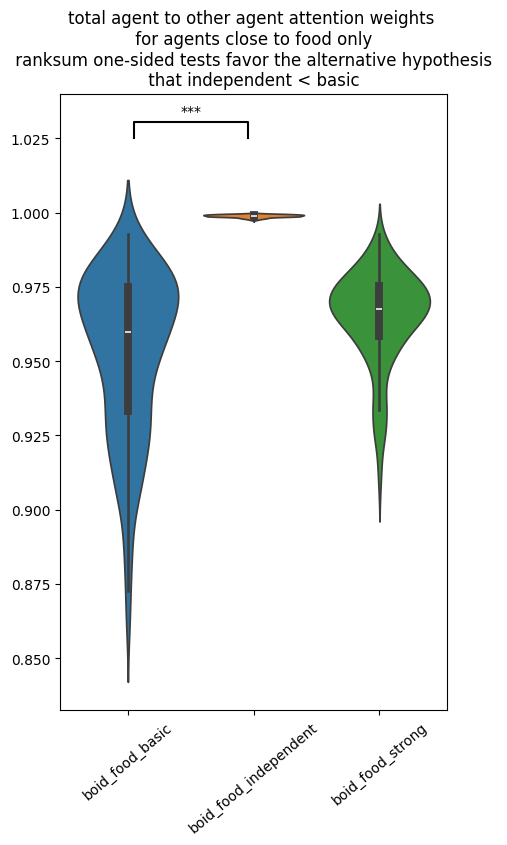

In [68]:
order = range(3)#[0,1,2]
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(5, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_diag_close_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("total agent to other agent attention weights \n for agents close to food only \n ranksum one-sided tests favor the alternative hypothesis \n that independent < basic ")

# Annotate significance
annotations = [(0, 1, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig(f"food_attention_weights_close{'_selfloops' if self_loops else ''}{'_rp' if relative_positions else ''}.pdf", bbox_inches="tight")

## Figures for final version of NeurIPS Workshop paper

### figure_data_D_updated() computes the following. 

Assume $n$ agents and attention weights $\alpha_{ij}$ for node $i$ attending to node $j$. 

<BR>

**mean_agent_to_self_in_frame** = $\displaystyle \frac{1}{n}\left(\displaystyle \sum_{i=1}^n \alpha_{ii}\right)$

<br>

**mean_agent_to_other_agent_in_frame** = $\displaystyle \frac{1}{n}\left(\displaystyle \sum_{i=1}^n \sum_{\substack{j=1 \\ j \neq i}}^n \alpha_{ij}\right)$  (I believe this denominator should be $n$ not $n-1$ as we thought earlier today, because we are taking the average of all the $i$'s not the $j$'s.)


<br> 

**mean_agent_to_food_in_frame** = $\displaystyle \frac{1}{n}  \left(\displaystyle \sum_{i=1}^n \alpha_{if}\right)$, assuming for now there is one food index $f$. This needs to be fixed if there is more than one food index -- the formula should be the same as agent to other agent but with $j$ running over the food indices. 

<br>

Each of these is averaged over the total number of frames in the file, and a list for each with this average (one entry for each file) is returned. 




<br>



$$
\left[\frac{1}{T}\displaystyle \sum_{t = 1}^T \left(\displaystyle \frac{1}{n} \sum_{i=1}^n \sum_{j \neq i} \alpha_{ij}^t\right)\right]_{k = 1}^{F}
$$



In [69]:

def figure_data_D_updated(datasets, all_combinations, m_x, W, start = 0, end = 50):
    """
    For each file, calculates the average over each frame of the average over each agent of:
        -- the agent to other agent attention weights
        -- the agent to food attention weight
        -- the agent to self attention weight
    """

    dataname, _, _, _, _, _, _ = all_combinations[m_x]
    dataloader = datasets[dataname]["test_loader"]
    
    _, species = list(dataloader)[0]
    all_bird_indices = species.ravel() == 0 #exclude food/environmental factor
    food_indices = species.ravel() == 1
    num_agents = np.count_nonzero(all_bird_indices)
        
    agent_to_other_agent_all = []
    agent_to_food_all = [] 
    agent_to_self_all = []
 
    for file in W[0].keys():

        agent_to_other_agent_in_file = []
        agent_to_self_in_file = []
        agent_to_food_in_file = []

        for frame in range(start, end):
      
            #
            # Get a copy of the attention weights for this frame in the current file 
            # 
            attention_weights = W[0][file][frame].copy().T

            #
            # Calculate the average agent to self attention weights in this frame 
            #
            mean_agent_to_self_in_frame = np.mean(attention_weights[all_bird_indices][: , all_bird_indices].diagonal())

            #
            # Zero out the diagonal to calculate the agent to other agent attention level 
            #
            np.fill_diagonal(attention_weights, 0.0)

            #
            # Calculate the average agent to other agent attention weights and agent to food attention weights in this frame
            #
            mean_agent_to_other_agent_in_frame = np.sum(attention_weights[all_bird_indices][:, all_bird_indices])/(num_agents)
            mean_agent_to_food_in_frame = np.mean(attention_weights[all_bird_indices][:, food_indices])

            
            #
            # Add frame means to list for this file. 
            #
            agent_to_other_agent_in_file.append(mean_agent_to_other_agent_in_frame)
            agent_to_food_in_file.append(mean_agent_to_food_in_frame)
            agent_to_self_in_file.append(mean_agent_to_self_in_frame)

        #
        # Compute means over this file and append to lists to be returned 
        #
        agent_to_other_agent_all.append(np.mean(agent_to_other_agent_in_file))
        agent_to_self_all.append(np.mean(agent_to_self_in_file))
        agent_to_food_all.append(np.mean(agent_to_food_in_file))
    
    
    return agent_to_other_agent_all, agent_to_food_all, agent_to_self_all


In [70]:
MODEL_START_TIME = 5 #: W_output_all starts to record at frame 5
start = 0
end = 50

entropy_all = {}
sum_agent_to_other = {}
sum_agent_to_food = {}
sum_agent_to_self = {}
sum_diag_close = {}
for m in models_to_consider:
   sum_agent_to_other[m], sum_agent_to_food[m], sum_agent_to_self[m], = figure_data_D_updated(datasets, all_combinations, m, W_output_all[m], start, end)

In [71]:
sum_agent_to_food_df = pd.DataFrame(sum_agent_to_food) # how much does the agent pay attention to food
sum_agent_to_other_df = pd.DataFrame(sum_agent_to_other) # how much does the agent pay attention to other agents 
sum_agent_to_self_df = pd.DataFrame(sum_agent_to_self) # how much does the agent pay attention to itself

In [72]:
for i in range(len(sum_agent_to_self)): 
    print(f'diag {i} mean ', np.mean(sum_agent_to_self[i]), len(sum_agent_to_self[i]), 
                        np.nanmean(sum_agent_to_other[i]), np.count_nonzero(~np.isnan(sum_agent_to_other[i])), 
                        np.nanmean(sum_agent_to_food[i]), np.count_nonzero(~np.isnan(sum_agent_to_food[i])), 
                        all_combinations[i] )

diag 0 mean  0.9708902 300 0.028516681028585882 300 0.000593082 300 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 6, 0)
diag 1 mean  0.9991973 300 0.0007580883228408251 300 4.467034e-05 300 ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 6, 0)
diag 2 mean  0.9680485 300 0.031063275577227274 300 0.00088817935 300 ('boid_food_strong', 'vpluspplus_a', 0, 1, 0.1, 8, 0)


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_2879/1641616306.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


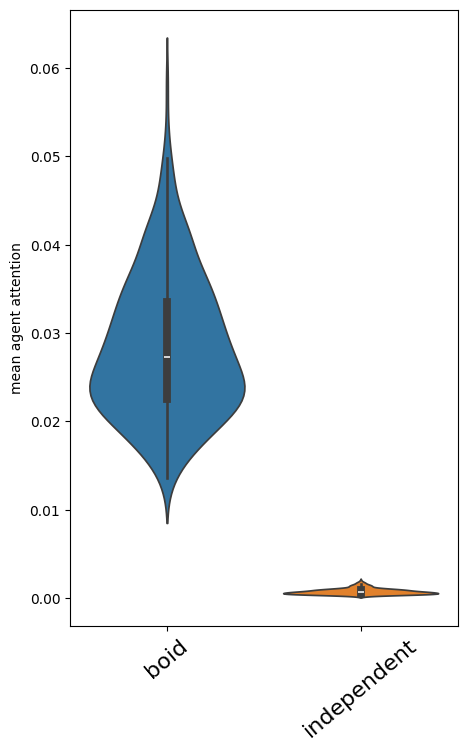

In [73]:

order = range(2)
fig, axes = plt.subplots(nrows=1, ncols=1,
                        #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
                        figsize=(5, 8))
ax = sns.violinplot(sum_agent_to_other_df, ax = axes, palette=my_pal, order = order)
ticklabels = ['boid', 'independent']
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.tick_params(axis='x', labelsize=16)
ax.set_ylabel("mean agent attention")

#nAnnotate significance
#annotations = [(0, 1, 0.001)]
#starbars.draw_annotation(annotations)
plt.savefig(f"figure_food_agent_to_other_agent_attention{'_selfloops' if self_loops else ''}{'_rp' if relative_positions else ''}.png", bbox_inches="tight")

In [74]:
print(sum_agent_to_food_df.head())
print('sum food \n', sum_agent_to_food)
print('sum bird \n', sum_agent_to_other)

          0         1         2
0  0.000853  0.000060  0.001121
1  0.000117  0.000029  0.000551
2  0.000864  0.000059  0.001061
3  0.000605  0.000050  0.000803
4  0.000201  0.000031  0.000373
sum food 
 {0: [0.0008530327, 0.00011724441, 0.0008640476, 0.00060514477, 0.00020058932, 0.0005484356, 0.00018222575, 0.00053853134, 0.0009004136, 0.0008464784, 0.00045076318, 0.0008487014, 0.0004702356, 0.0004628721, 0.00048154895, 0.000727441, 0.0006293607, 0.0009511576, 0.00060497446, 0.0009332943, 0.0005953116, 6.8830115e-05, 7.807933e-05, 0.0002044082, 0.0007217851, 0.0003052775, 0.00012969173, 0.0008228219, 9.859823e-05, 0.0006794345, 0.0008725939, 0.0007407815, 0.0009626648, 0.0007726548, 0.00038469527, 0.000989459, 0.00095473864, 0.00031709007, 0.0005577274, 0.00069962844, 8.121252e-05, 0.0007230378, 0.0003274014, 9.8598815e-05, 4.07187e-05, 0.00062332285, 0.00017404734, 0.00041779422, 0.0008013536, 0.0002753266, 0.00069154246, 0.0009210594, 0.0006144417, 0.0008939983, 0.00030733328, 0.000

### Boid to boid

In [75]:
_, pvalue01_boid_gt_ind = ranksums(sum_agent_to_other_df[0], sum_agent_to_other_df[1],'greater',nan_policy = 'omit')
_, pvalue02_boid_lt_strong = ranksums(sum_agent_to_other_df[0], sum_agent_to_other_df[2],'less',nan_policy = 'omit')
_, pvalue03_boid = ranksums(sum_agent_to_food_df[0], sum_agent_to_food_df[2],'less',nan_policy = 'omit')
_, pvalue04_ind = ranksums(sum_agent_to_other_df[1], sum_agent_to_food_df[1],'greater',nan_policy = 'omit')
_, pvalue05_strong = ranksums(sum_agent_to_other_df[2], sum_agent_to_food_df[2],'greater',nan_policy = 'omit')
_, pvalue01_boid_gt_ind_diag = ranksums(sum_agent_to_self_df[0], sum_agent_to_self_df[1],'less',nan_policy = 'omit')
_, pvalue02_boid_lt_strong_diag = ranksums(sum_agent_to_self_df[0], sum_agent_to_self_df[2],'greater',nan_policy = 'omit')

#print(pvalue01_boid_gt_ind, pvalue02_boid_lt_strong, pvalue03_boid, pvalue04_ind, pvalue05_strong )
print(pvalue01_boid_gt_ind, pvalue02_boid_lt_strong, pvalue03_boid, pvalue04_ind, pvalue05_strong, pvalue01_boid_gt_ind_diag, pvalue02_boid_lt_strong_diag )

5.248498215281986e-100 4.197923294989939e-06 5.327110261177098e-20 5.248498215281986e-100 5.248498215281986e-100 5.248498215281986e-100 7.529644049856846e-07


3


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_2879/4158115771.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


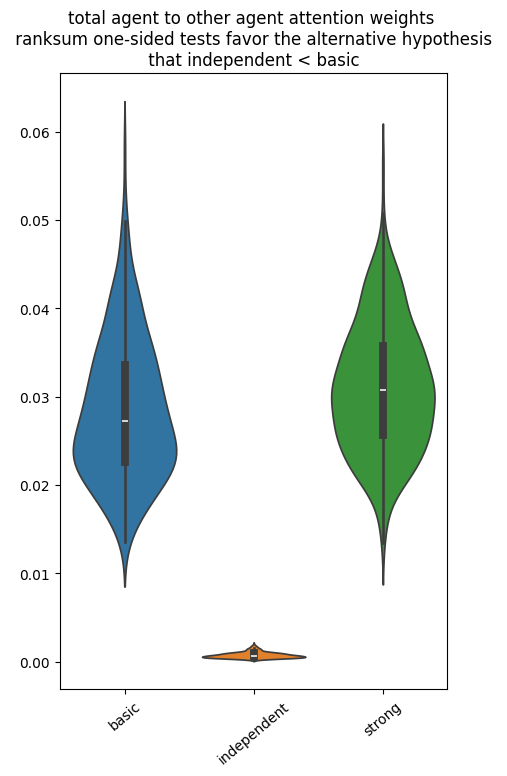

In [76]:
print(len(sum_agent_to_self))
order = range(3)#[0,1,2]
ticklabels = ['basic', 'independent', 'strong']
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(5, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_agent_to_other_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("total agent to other agent attention weights \n ranksum one-sided tests favor the alternative hypothesis \n that independent < basic ")

# Annotate significance
#annotations = [(0, 1, 0.001)]
#starbars.draw_annotation(annotations)
plt.savefig(f"food_adj_boid_sum_diag{'_selfloops' if self_loops else ''}{'_rp' if relative_positions else ''}.pdf", bbox_inches="tight")

In [77]:
#new_df = pd.DataFrame({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]})
#print(new_df.head())
#print('sum bird', sum_bird_df[0].shape)
#print('sum food', sum_food_df[0].shape)
#order = [0,1]

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
## ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
#sns.violinplot(new_df)

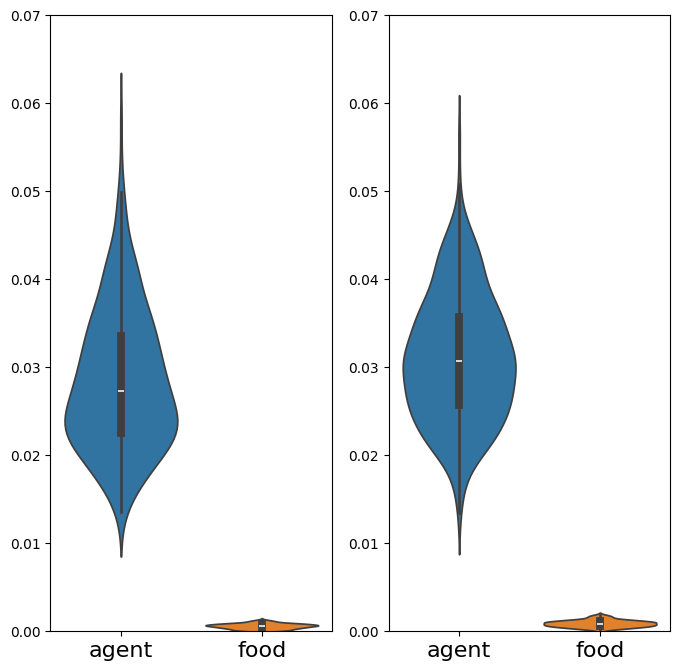

In [78]:

order = [0,2]
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(8, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
for i, model in enumerate(order):
    new_df = pd.DataFrame({'agent': sum_agent_to_other_df[model], 'food': sum_agent_to_food_df[model]})
    sns.violinplot(new_df, ax = axes[i])
    axes[i].tick_params(axis='x', labelsize=16)
    axes[i].set_ylim(-0.0,0.07)

#axes[0].set_title('basic')
#axes[1].set_title('independent')
#axes[1].set_title('strong')

#ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
#fig.suptitle("comparison of boid to other boids \n and boid to food attention weights")

plt.savefig(f"figure_boid_to_food_comparison{'_selfloops' if self_loops else ''}{'_rp' if relative_positions else ''}.png", bbox_inches="tight")

In [79]:
#new_df = pd.DataFrame({'boid-boid': sum_bird_df[1], 'boid-food': sum_food_df[1]})

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
## ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
#sns.violinplot(new_df)

In [80]:
#new_df = pd.DataFrame({'boid-boid': sum_bird_df[2], 'boid-food': sum_food_df[2]})

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
## ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
#sns.violinplot(new_df)

### Boid to food

In [81]:
_, pvalue01 = ranksums(sum_agent_to_food_df[0], sum_agent_to_food_df[1],'greater',nan_policy = 'omit')
_, pvalue02 = ranksums(sum_agent_to_food_df[0], sum_agent_to_food_df[2],'greater',nan_policy = 'omit')
_, pvalue03 = ranksums(sum_agent_to_food_df[1], sum_agent_to_food_df[2],'less',nan_policy = 'omit')
print(pvalue01, pvalue02, pvalue03)

4.2067512665917587e-95 1.0 1.586772508897244e-98


3.0 0.03


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_2879/3359238556.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


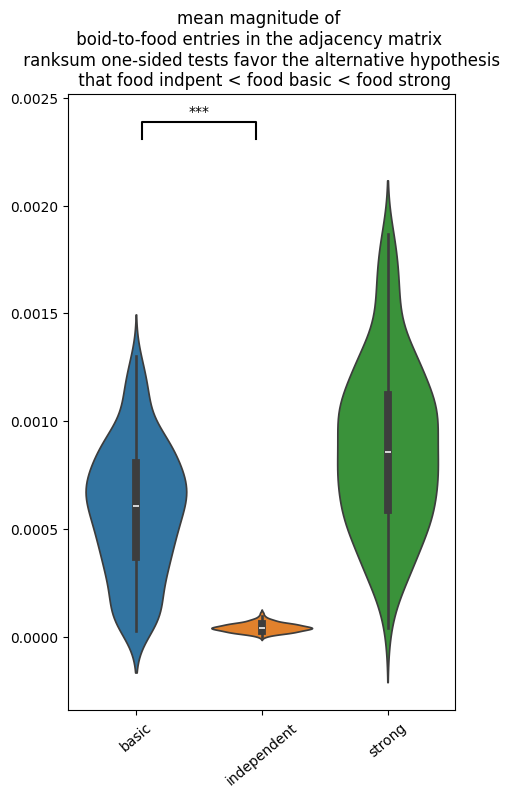

In [82]:
order = range(3)
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(5, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_agent_to_food_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("mean magnitude of \n boid-to-food entries in the adjacency matrix  \n ranksum one-sided tests favor the alternative hypothesis \n that food indpent < food basic < food strong")

# Annotate significance
annotations = [(0, 1, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig("food_adj_food_sum{'_selfloops' if self_loops else ''}.pdf", bbox_inches="tight")


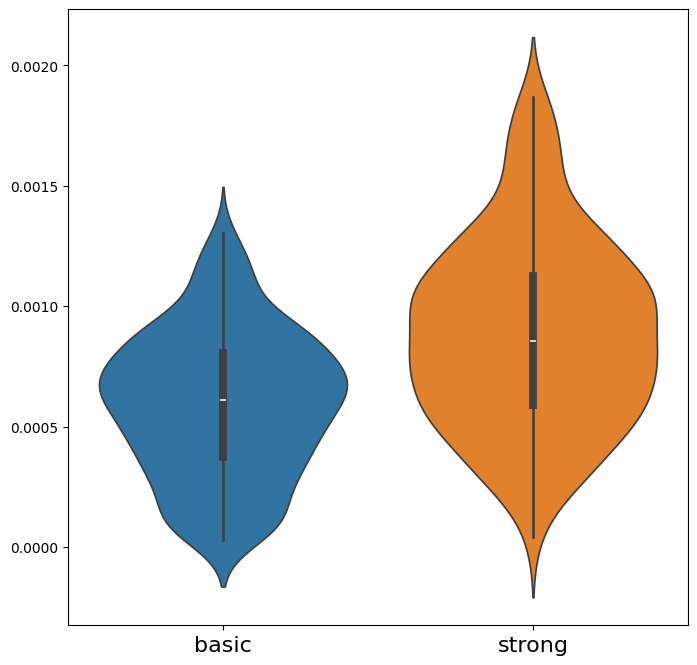

In [83]:

order = [0,2]
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(8, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid

new_df = pd.DataFrame({'basic': sum_agent_to_food_df[0], 'strong': sum_agent_to_food_df[2]})
sns.violinplot(new_df, ax = axes)
axes.tick_params(axis='x', labelsize=16)
# axes.set_ylim(-0.0,0.07)
plt.savefig(f"food_to_food_comparison_sum{'_selfloops' if self_loops else ''}.png", bbox_inches="tight")